# Markov chain impementation to predict rainy day event

This notebook is intended to help beginner (me included) to implement markov chain and fourier regression (much later) to see the probability of weather to happen based on events from the past.

Markov stated that event that happens today is affected by event happened on short event before. So the probability of this day to be rainy is affected by yesterday's weather condition, wether it was clear or rainy

### Disclaimer
I am no expert in any way and have no intention to school you in any way. hell, my english is not even that good. use this notebook as an inspiration properly, and this shouldn't serve as your primary source of how-to.

Some of the steps in this notebook are borrowed from my colleagues, Mr. Benny Istanto and Ms. Nastiti Andini.
Shoudl you have any question, you know where you should go to


In [46]:
import os
import numpy as np
import pandas as pd
import time
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sb


In [47]:
pwd = os.getcwd()
dir_input = os.path.join(pwd, 'Input')
dir_out = os.path.join(pwd, 'Output')
MAGIC = 69

## 1. Importing dataframe, do some prerequisite

Let's begin with importing our dataframe. I prefer dataframe in long format, as it is much easier to read and implement operations. Also, it helps the machine to process the commands. 
Data input used in this notebook should be in csv format. feel free to adjust your input and tinker with the command i use here.

In [48]:
file_csv = glob.glob(os.path.join(dir_input, '*hujan*.csv'))[0]
df_ = pd.read_csv(file_csv)
df_.head(4)

,Tahun,Bulan,Tanggal,Data
0,1986,1,1,0.0
1,1986,1,2,2.0
2,1986,1,3,0.0
3,1986,1,4,19.0


we will first create a new column that contain all the date in datetime format, so we will later be able to utilize pandas dataframe to our advantage. we should also create event based on our rainfall value, in this case is in "Data" column, to 1 as rainy day, and 0 as no-rain day.

rainy day is defined as day with rainfall < 1 (<0.9mm), and clear day (0) as 0-0.9mm.

we will also create a column that reflect the date time in datetime format like mentioned above.

Note: to make everything much simpler, i choose to just omit the 29th Feb entirely and then adjust the column 'Hari_ke' so that instead of 366, all leap year only has 365

### important: this step, in which we just simply ommit the 29th Feb only serves as a hackaround and temporary only solution. 

In [49]:
df_['Date_'] = pd.to_datetime(df_[['Tahun', 'Bulan', 'Tanggal']].astype(
    str).apply('-'.join, axis=1))
df_['Date_'] = pd.to_datetime(df_['Date_']).dt.date
df_['rain_event'] = df_['Data'].apply(lambda x: 1 if x > 0.9 else 0)
df_['Date_'] = pd.to_datetime(df_['Date_'])
df_['Hari_ke'] = df_['Date_'].dt.dayofyear
kabisat = df_[df_['Date_'].dt.is_leap_year]['Date_'].dt.year.unique()
df_['geser'] = df_['Date_'].dt.year.isin(kabisat) & (df_['Date_'].dt.month > 2)
df_['geser'] = df_['geser'].astype(int)  # Ubah tipe data menjadi integer (0 atau 1)
df_['Hari_ke'] = df_['Hari_ke'] - df_['geser']
df_ = df_.drop('geser', axis=1)
# df_['Kabisat'] = df_['Date_'].dt.is_leap_year
df_.head(10)

,Tahun,Bulan,Tanggal,Data,Date_,rain_event,Hari_ke
0,1986,1,1,0.0,1986-01-01,0,1
1,1986,1,2,2.0,1986-01-02,1,2
2,1986,1,3,0.0,1986-01-03,0,3
3,1986,1,4,19.0,1986-01-04,1,4
4,1986,1,5,0.0,1986-01-05,0,5
5,1986,1,6,1.0,1986-01-06,1,6
6,1986,1,7,0.0,1986-01-07,0,7
7,1986,1,8,0.0,1986-01-08,0,8
8,1986,1,9,0.0,1986-01-09,0,9
9,1986,1,10,0.0,1986-01-10,0,10


### step 1 is done!!!!
important feat: we finally able to get rain_event kolom. this is important as it will stand as a guidance for our next step. do some minor adjustment if needed. I don't think i should lol

## 2. Create columns that consists of conditional event

this step is necessary as we want to obtain the events that follows markov chain. basically we are to create 8 possible event of yes (1) or no (0) rainfall that occured to our desired day, with the weather of 2 prior days being the conditional terms. 
to do this, we can loop through the pattern assigned below.

In [50]:
# n_001 = np.zeros(len(df_))

# Mencari indeks pertama kejadian hujan dengan pola 001
# for i in range(2, len(df_)):
#     if df_['rain_event'].iloc[i] == 1 and df_['rain_event'].iloc[i-1] == 0 and df_['rain_event'].iloc[i-2] == 0:
#         n_001[i] = 1

pola = ['001', '011', '111', '010', '110', '101', '100', '000']

# Looping untuk membuat kolom baru dengan pola yang berbeda
for pola_ in pola:
    array = []
    for i in range(len(df_)):
        if i >= 2:
            if (df_['rain_event'].iloc[i-2] == int(pola_[0]) and
                df_['rain_event'].iloc[i-1] == int(pola_[1]) and
                df_['rain_event'].iloc[i] == int(pola_[2])):
                array.append(1)
            else:
                array.append(0)
        else:
            array.append(np.nan)
    
    df_['n_' + pola_] = array


df_.head(20)


,Tahun,Bulan,Tanggal,Data,Date_,rain_event,Hari_ke,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000
0,1986,1,1,0.0,1986-01-01,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986,1,2,2.0,1986-01-02,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986,1,3,0.0,1986-01-03,0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1986,1,4,19.0,1986-01-04,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1986,1,5,0.0,1986-01-05,0,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1986,1,6,1.0,1986-01-06,1,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1986,1,7,0.0,1986-01-07,0,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1986,1,8,0.0,1986-01-08,0,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1986,1,9,0.0,1986-01-09,0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1986,1,10,0.0,1986-01-10,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### step 2 is done

Now we have event that matches each pattern that we want.
next we want to aggregate this number of event into each day, i.e. day 1 to 366.
for this, we need to make a new dataframe that has 366 rows, each containing the number of event
for each pattern.
Later we will use this newly created dataframe to make probility for each event, and later transform it to 
g1, following logit function

feat: we now have 8 more colums from our og dataframe, df_. This new 8 columns basically will serve as our lead for the next step, to calculate the probability p of certain conditional event.

## 2.5. create an empty dataframe of df_event

this dataframe, like aforementioned above will serve as the total number of conditional event. 

In [51]:
kolom = df_.columns[7:]
kolom = ['Tanggal'] + list(kolom)
df_event = pd.DataFrame(0, index=range(len(df_.Hari_ke.unique())), columns=kolom)
df_event

,Tanggal,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
360,0,0,0,0,0,0,0,0,0
361,0,0,0,0,0,0,0,0,0
362,0,0,0,0,0,0,0,0,0
363,0,0,0,0,0,0,0,0,0


Now let's popualte df_event with the sum of all event we previously made from our og dataframe, df_.
we do this by looping through the 'Hari_ke' unique value, 1-365 (we ommited the 29th Feb, do you packing remember?!).
This way we can obtain the value of events occured.

### important: this step only serves as a temporary 

In [52]:
uruthari = df_.Hari_ke.unique()

for urut in uruthari:
    df_pilih = df_.loc[df_.Hari_ke == urut]
    jumlah = df_pilih.iloc[:, 7:].sum()
    
    df_event.loc[urut-1, 'Tanggal'] = urut
    df_event.iloc[urut-1, 1:] = jumlah

df_event.head(5)

,Tanggal,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000
0,1,3,3,5,5,1,2,5,10
1,2,5,4,6,1,2,3,3,10
2,3,4,4,9,5,1,0,3,9
3,4,6,1,6,3,7,3,3,6
4,5,3,2,4,7,3,1,9,6


Now that we have the essential dataframe, df_event, we can finally calculate the chance probability p for each event.
to calculate p we will use formula p(yes) = number of event (n) yes / number of event yes + n no
This way, if we are about to calculate the probability of rainy day from 2 consecutive dry days, i.e. p001, we will use formula
p_001 = n_001/ (n_000 + n_001)
we will use this simple formula calculate all the prob from our df_event

Do you still remember list of pola we defined above? yea, we will use that list again in this step

In [102]:
for pola_ in pola:
    panggil = 'n_' + pola_[:2]
    dummy = df_event.filter(regex=panggil).copy()
    panggil = dummy.columns
    dummy['gabung'] = dummy.loc[:, panggil[0]] + dummy.loc[:, panggil[1]]
    prob = dummy['n_'+pola_] / dummy['gabung']
    df_event['p_' + pola_] = prob
    print('p_{} is calculated'.format(pola_))

df_event.head(15)

p_001 is calculated
p_011 is calculated
p_111 is calculated
p_010 is calculated
p_110 is calculated
p_101 is calculated
p_100 is calculated
p_000 is calculated


,Tanggal,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000,p_001,...,p_100,p_000,g_001,g_011,g_111,g_010,g_110,g_101,g_100,g_000
0,1,3,3,5,5,1,2,5,10,0.230769,...,0.714286,0.769231,-1.203973,-0.510826,1.609438,0.510826,-1.609438,-0.916291,0.916291,1.203973
1,2,5,4,6,1,2,3,3,10,0.333333,...,0.500000,0.666667,-0.693147,1.386294,1.098612,-1.386294,-1.098612,0.000000,0.000000,0.693147
2,3,4,4,9,5,1,0,3,9,0.307692,...,1.000000,0.692308,-0.810930,-0.223144,2.197225,0.223144,-2.197225,-18.420681,18.420681,0.810930
3,4,6,1,6,3,7,3,3,6,0.500000,...,0.500000,0.500000,0.000000,-1.098612,-0.154151,1.098612,0.154151,0.000000,0.000000,0.000000
4,5,3,2,4,7,3,1,9,6,0.333333,...,0.900000,0.666667,-0.693147,-1.252763,0.287682,1.252763,-0.287682,-2.197225,2.197225,0.693147
5,6,1,1,4,3,2,4,6,14,0.066667,...,0.600000,0.933333,-2.639057,-1.098612,0.693147,1.098612,-0.693147,-0.405465,0.405465,2.639057
6,7,6,4,2,1,3,2,3,14,0.300000,...,0.600000,0.700000,-0.847298,1.386294,-0.405465,-1.386294,0.405465,-0.405465,0.405465,0.847298
7,8,4,4,5,4,1,2,2,13,0.235294,...,0.500000,0.764706,-1.178655,0.000000,1.609438,0.000000,-1.609438,0.000000,0.000000,1.178655
8,9,2,3,6,3,3,3,2,13,0.133333,...,0.400000,0.866667,-1.871802,0.000000,0.693147,0.000000,-0.693147,0.405465,-0.405465,1.871802
9,10,4,1,7,4,2,3,3,11,0.266667,...,0.500000,0.733333,-1.011601,-1.386294,1.252763,1.386294,-1.252763,0.000000,0.000000,1.011601


## 3. convert the probability into logit

In the next step, we will convert the probability we have into logit. this operation is also known as
logit transformation (duh!). This step is necessary as it is very common in regression analysis that
involves probability. in regression, we usually want to fit a line that can predict predictand. 
If we still use probability, without any transformation, there is a high chance that we will have a regression
line less than 0, and higher than 1. This is not possible, as probability only ranges from 0 (impossible) to 1 (yea idk what is the english word to it, fox)

feat (so far): probability of event is now obtained!

#### important: in numpy, natural logarithm is done with np.log. if we instead want to do log with 10 as base number, we use np.log10 instead.

#### also before conducting logit transformation, we need to make sure that our og probability is slightly above 0 and just a bit below 1. pay attention to .replace command i did below, yea?

before i forget, just to make sure that we do it properly, we will change the value of 0 and 1 (mentioned above) only on p_000 to p_111 columns. we will loop through those columns. yea i know that i might not be most pythonic way to do things, it's just my way of making sure we get the desired results. just bear with me, will ya?

In [54]:
# loop through the p_ columns and replace the value of 0 and 1

for pola_ in pola:
    panggil = 'p_' + pola_
#     change the value of 0 prob to 10^-8. yea, tis a tiny bit
    df_event[panggil] = df_event[panggil].replace(0, 0.00000001)
    #     change the value of 1 prob to 0.99999999
    df_event[panggil] = df_event[panggil].replace(1, 0.99999999)
    
#     convert 'p_' to 'g_' with logit transformation
    df_event['g_'+pola_] = np.log(df_event[panggil] / (1 - df_event[panggil]))
    
    print('transformation done, you now have g_{} column'.format(pola_))



transformation done, you now have g_001 column
transformation done, you now have g_011 column
transformation done, you now have g_111 column
transformation done, you now have g_010 column
transformation done, you now have g_110 column
transformation done, you now have g_101 column
transformation done, you now have g_100 column
transformation done, you now have g_000 column


In [55]:
# have a look of our newly created dataframe. yea it's getting crowded now
df_event.tail(4)

,Tanggal,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000,p_001,...,p_100,p_000,g_001,g_011,g_111,g_010,g_110,g_101,g_100,g_000
361,362,2,4,4,3,6,3,2,11,0.153846,...,0.400000,0.846154,-1.704748,0.287682,-0.405465,-0.287682,0.405465,0.405465,-0.405465,1.704748
362,363,4,1,4,4,4,3,6,9,0.307692,...,0.666667,0.692308,-0.810930,-1.386294,0.000000,1.386294,0.000000,-0.693147,0.693147,0.810930
363,364,6,2,2,5,3,3,5,9,0.400000,...,0.625000,0.600000,-0.405465,-0.916291,-0.405465,0.916291,0.405465,-0.510826,0.510826,0.405465
364,365,5,3,3,6,1,3,5,9,0.357143,...,0.625000,0.642857,-0.587787,-0.693147,1.098612,0.693147,-1.098612,-0.510826,0.510826,0.587787


### 4. fitting fourier regression

This is a crucial step, as this will give us the equation of fourier regression that we can later us to predict the probability of conditional rainy/no-rain day.

We will begin by creating an empty dataframe, FR_input (you guessed it bro, FR stands for fourier regression).
This dataframe will be later be populated with fourier regression coefficient.
Also to make things rather neat (at least imo), we will also add the g_000 - g_111 into the FR_input.

How do we solve/fit FR? With a strong mind and some typing ofc (duh!).
We will use scipy's curve fit to fit the fourier regression and determine the optimum coef.
we will define the equation, then employ curve_fit to fit.
the result of this fitting process is the regression equation.

Remember several things:
1. Fourier regression, just like other regression, needs predictor and predictand. on our case, the predictor is the time, t' (Mr. Boer refer to this as t prime. dont confuse it with optimus prime). the predictand, as you may have guessed, is the the g_000 - g_111
2. Fourier regression will also produce a fit line. The difference is that instead of straight line, FR line is cyclical (in some way) as it contains sin and cos function
3. as with other regression anal, no nan is allowed. we tackle this problem by dropping the nan value in our dataset. we first join the 2 dataframe, then dropna the newly created dataframe. This way we ensure that nan from other column wont affect nan from our desired dataframe

In [56]:
# bikin df baru fourier_koef dan df untuk input fourier regression
from scipy.optimize import Bounds

fourier_koef = pd.DataFrame(
    0, columns=('a0', 'a1', 'b1', 'a2', 'b2'), index=pola)
FR_input = pd.DataFrame()
FR_input['t_prime'] = df_event.Tanggal*2*np.pi/max(df_event.Tanggal)
FR_input = FR_input.join(
    df_event.loc[:, df_event.columns.str.startswith('g_')])

# define fungsi regresi fourier 2 harmoni. klo mau pake 3 harmoni ya urusanmu su

def reg_fourier(t, a0, a1, b1, a2, b2):
    return a0 + a1 * np.cos(t) + b1 * np.sin(t) + a2 * np.cos(2 * t) + b2 * np.sin(2 * t)

# fitting fourier function, pake bantuan package curve_fit ya su masa manual
# karena kita punya 8 prediktan, ya fitting dilakukan sebanyak 8 kali ya. bisa ngitung kan?
# wah wah, baru nyadar klo masing2 g_ itu bakal punya persamaan sendiri2?
# ya sama kita. sama2 tolol wkwkwkk

list_prediktan = FR_input.columns[1:]
batas_bawah = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
batas_atas = [np.inf, np.inf, np.inf, np.inf, np.inf]

for y_in, pola_ in zip(list_prediktan, pola):
    
    dfinput = FR_input[['t_prime', y_in]].copy()
    dfinput = dfinput.dropna()
    popt, pcov = curve_fit(
        reg_fourier, dfinput['t_prime'], dfinput[y_in], bounds=(batas_bawah, batas_atas))
    fourier_koef.loc[pola_, :] = popt

fourier_koef


,a0,a1,b1,a2,b2
001,-1.725973,0.941887,0.804554,-0.267171,-0.485620
011,0.776672,-2.168675,0.108175,0.782735,0.472460
111,0.523558,-0.560657,-0.071075,0.566091,-0.094020
010,-0.776672,2.168675,-0.108175,-0.782735,-0.472460
110,-0.523558,0.560657,0.071075,-0.566091,0.094020
101,-1.763898,-1.120066,0.613543,0.702583,-0.293925
100,1.763898,1.120066,-0.613543,-0.702583,0.293925
000,1.725973,-0.941887,-0.804554,0.267171,0.485620


To our surprise (at least i am), our model does not seem to be able to fit properly. Multiple warnings popped-up, saying that covariance of the param can't be estimated. Both a2 and b2 coef for all conditions also = 1, which does not seem fine at all.

I suspected there are 2 reasons behind this:
1. either the data still contains some rubbish, like infs or nans, or perhaps too many value close to either one of them (which tbh doesn't seem to be the cause. we cleaned the data properly, remember?)
2. Model isn't able to explain the variance of conditional rainfall event in Kairatu. Either we go with other non-linear regression type, add more harmonics, or simply change location. This model didn't show much ability in explaining, hence predicting, rainfall event in Kairatu

This begs other possibility: is there any easy fix to this problem?

We should take a detour and evaluate and perhaps adjust our model, following the pre-analysis in point 2.
Next: try to plot the result and see for ourselves how is the distribution, and model's regression line fit to the distribution.

#### feat: we manage to obtain regression coef. All is well lol
well done!

### 5.1. "predict" the logit probability g0

First we will implement the regression model we have and apply it to our predictor.
Then we will visualize the result we have so far. We hope to gain more understanding about the built model if it fits the data or not.
The next things we will do are as follow:
1. "predict" g0 using FR created in previous step. We will make and populate df result_ for this
2. scatter plot the prediction along with the actual event. What we're about to plot are the g0 result, not the actual final probability. we might do it later, but for now we want to see how our regression line sits among the actual g0.

Remember that when we fit the FR we transform the logit? we will transform it back with inverse logit function

feat: we now have several dfs: fourier_koef (our regression coefs are stored here), FR_input (our inputs)

In [57]:
result_ = FR_input[['t_prime']].copy()  # this will serve as our result df

# def the reg equation stored in fourier_koef df

def hitung_FR(t, lis_):
    """
    use this function to call the obtained fourier reg coef
    and calculate the prob logit
    be sure to use tprime as input t here
    """
    a0, a1, b1, a2, b2 = lis_
    hasil_ = a0 + a1 * np.cos(t) + b1 * np.sin(t) \
        + a2 * np.cos(2 * t) + b2 * np.sin(2 * t)
    return hasil_

def logit_inv(logit):
    """
    this simple function is basically
    an anti-logit transformation,
    to revert back the logit var into probability
    yea look it up on google, man
    """
    hasil_p = 1 / (1 + np.exp(-logit))
    return hasil_p

def inverse_logit(logit):
    return 1 / (1 + np.exp(-logit))
# loop through all list pola, calling the fourier_koef
# and calculate g0 predict

for pola_ in pola:
    
    lis_ = fourier_koef.loc[pola_, :]
    hasil_ = hitung_FR(result_['t_prime'], lis_)
    result_['g_FR_'+pola_] = hasil_
    
    # revert hasil_, a logit var, into probability var
    hasil_p = logit_inv(result_['g_FR_'+pola_])
    result_['res_p_'+pola_] = hasil_p
    
    print('g_'+pola_+' is done')

result_.tail(3)

g_001 is done
g_011 is done
g_111 is done
g_010 is done
g_110 is done
g_101 is done
g_100 is done
g_000 is done


,t_prime,g_FR_001,res_p_001,g_FR_011,res_p_011,g_FR_111,res_p_111,g_FR_010,res_p_010,g_FR_110,res_p_110,g_FR_101,res_p_101,g_FR_100,res_p_100,g_FR_000,res_p_000
362,6.248757,-1.045464,0.260097,-0.646067,0.343876,0.536898,0.631090,0.646067,0.656124,-0.536898,0.368910,-2.183279,0.101262,2.183279,0.898738,1.045464,0.739903
363,6.265971,-1.048371,0.259538,-0.627535,0.348070,0.533199,0.630229,0.627535,0.651930,-0.533199,0.369771,-2.182076,0.101372,2.182076,0.898628,1.048371,0.740462
364,6.283185,-1.051257,0.258984,-0.609267,0.352226,0.528992,0.629248,0.609267,0.647774,-0.528992,0.370752,-2.181382,0.101435,2.181382,0.898565,1.051257,0.741016


and with that, we now have result_ df, containing both logit and probability value following each conditions (pola).

yea we're closing on the end i think. 

#### 5.2. Plot result, logit with the built fourier reg vs logit obs (kinda)

We will try to how well the FR fit the transformed probability. Just 

feat: result_ df, containing fitted g_ and p_; and ofc fourier_koef that store the reg coef.


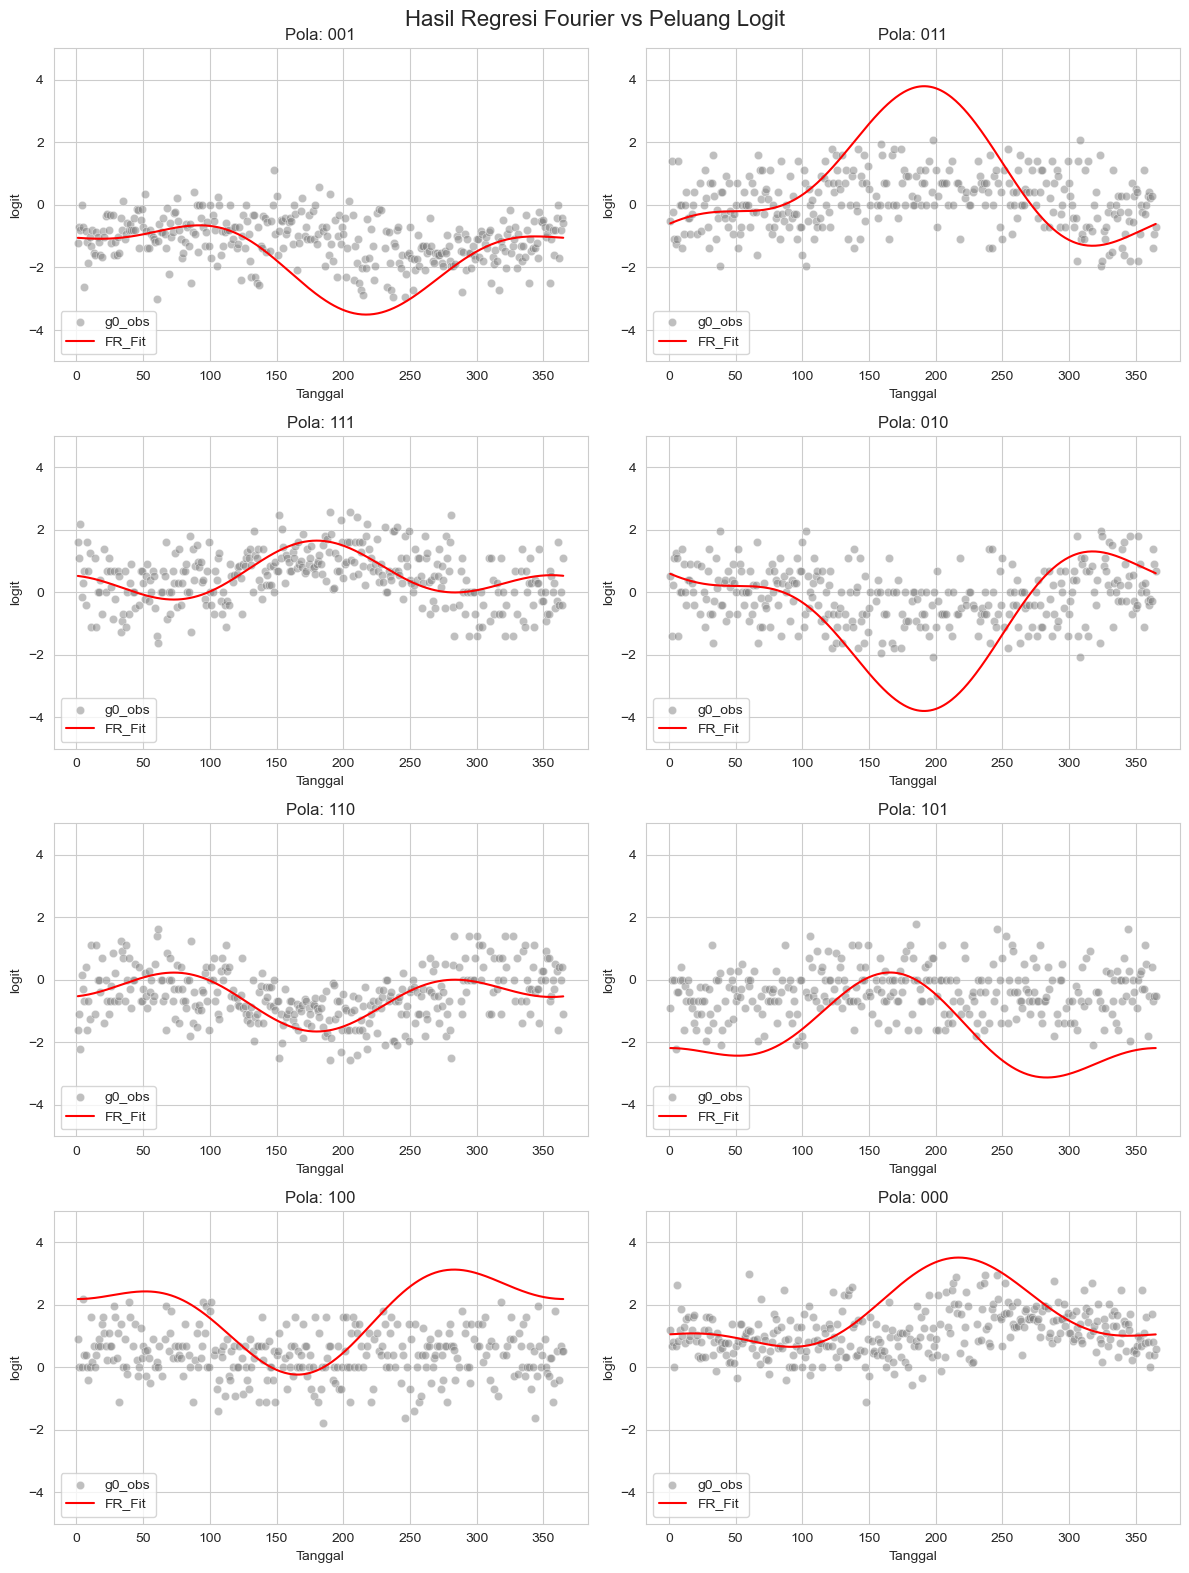

In [58]:
sb.set_style("whitegrid")
sb.set_palette("husl")
# sb.set_palette("pastel")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

def gambar_hasil(df_plot, pola_, ax):
    """
    this function will simply help you plot your 
    result, scatter and line
    """
    g_obs = 'g_{}'.format(pola_)
    gfit = 'g_{}_FR'.format(pola_)
    scatter = sb.scatterplot(
        data=df_plot, x='Tanggal', y=g_obs, ax=ax, color='grey', alpha=0.5)
    line = sb.lineplot(
        data=df_plot, x='Tanggal', y=gfit, ax=ax, color='red')
    
    ax.set_ylabel('logit')
    ax.set_ylim(-5, 5)
    ax.legend(
        handles=[scatter.collections[0], line.lines[0]],
        labels=['g0_obs', 'FR_Fit'], loc='lower left')

# init the loop, biar kek orang bener
for i, pola_ in enumerate(pola):
    # mendapatkan letak ax(es) dari plot kita ya njing. sesuaikan 
    # dengan bentuk plotmu ya. disini pake 4x2
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # calling up necessary dframe, ya tentu result_ dan df_event su
    df_plot = pd.DataFrame({
        'Tanggal': df_event.Tanggal,
        'g_{}'.format(pola_): df_event.loc[:, 'g_' + pola_],
        'g_{}_FR'.format(pola_): result_.loc[:, 'g_FR_'+pola_]})

    gambar_hasil(df_plot, pola_, ax)
    ax.set_title('Pola: {}'.format(pola_))

judul = 'Hasil Regresi Fourier vs Peluang Logit'
plt.suptitle(judul, fontsize=16)
fig.tight_layout()
namafile = os.path.join(dir_out, 'Vis_FR_vs_g0.jpg')
plt.savefig(namafile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### 6.1. Estimate alpha and beta value of our dataset

As you may have known, in statistics there exists many distributions: gamma, normal, poisson, weibull, and so on.
To describe these distributions, we usually use alpha and beta. these values can at least give us some idea as to how our data will be projected/distribute along the form of distribution it follows.
For instance, say that our rainfall follows gamma distribution. 

If we have alpha and beta value, we can say that:
1. Alpha usually tells us about the shape of the gamma distribution our data make: skewness, curtosis. it also tells us how symmetric is our rainfall. A higher alpha value will result in a distribution that is more peaked and has a longer right tail. A lower alpha value will result in a distribution that is more spread out and has a shorter right tail.
2. beta tells us about scale of our dataset. the higher the value, the wider the distribution will be. A higher beta value will result in a distribution that is more spread out. A lower beta value will result in a distribution that is more concentrated.


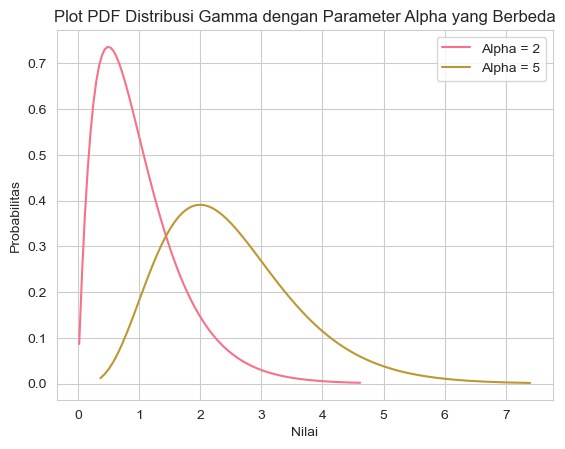

In [59]:
# this script is just an example of how alpha affect the distribution
from scipy.stats import gamma

beta = 2

# Distribusi Gamma pertama (alpha = 2)
alpha1 = 2
x1 = np.linspace(gamma.ppf(0.001, alpha1, scale=1/beta), gamma.ppf(0.999, alpha1, scale=1/beta), 100)
pdf1 = gamma.pdf(x1, alpha1, scale=1/beta)

# Distribusi Gamma kedua (alpha = 5)
alpha2 = 5
x2 = np.linspace(gamma.ppf(0.001, alpha2, scale=1/beta), gamma.ppf(0.999, alpha2, scale=1/beta), 100)
pdf2 = gamma.pdf(x2, alpha2, scale=1/beta)

# Plot
plt.plot(x1, pdf1, label='Alpha = 2')
plt.plot(x2, pdf2, label='Alpha = 5')
plt.xlabel('Nilai')
plt.ylabel('Probabilitas')
plt.title('Plot PDF Distribusi Gamma dengan Parameter Alpha yang Berbeda')
plt.legend()
plt.show()

Plot above shows that alpha = 2 has more decreasing probability of extreme event, thus a lighter tail, compared to alpha = 5.

Note:
As Mr. Boer requested us to generate the rainfall depth based on seasonal period, 
we will estimate our alpha and beta value from each season.
For this, we will divide the season into DJF, MAM, JJA, and SON.

each season will have their own a and b, so we will have 8 values of a and b.
We have 8 conditions of possible rainfall event, stated in list pola.
But we are instructed to only create rainfall depth on rainy event condition.
this means that we should only estimate a and b on n_001, n_011, n_111, and n_101.

to estimate these, we will call each row from each respective season and column 
mentioned above from dataframe df_ (remember this df?)

to help the calculation of MLE method, we will use scipy's package gamma.

here's what df_ looks like, last time we left it.
we will first create a new column in df_['Season'] using map function, then proceed

In [60]:
df_.head(10)

,Tahun,Bulan,Tanggal,Data,Date_,rain_event,Hari_ke,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000
0,1986,1,1,0.0,1986-01-01,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986,1,2,2.0,1986-01-02,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986,1,3,0.0,1986-01-03,0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1986,1,4,19.0,1986-01-04,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1986,1,5,0.0,1986-01-05,0,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1986,1,6,1.0,1986-01-06,1,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1986,1,7,0.0,1986-01-07,0,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1986,1,8,0.0,1986-01-08,0,8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1986,1,9,0.0,1986-01-09,0,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1986,1,10,0.0,1986-01-10,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
# off we go!
from scipy.stats import gamma

season_ = ['DJF', 'MAM', 'JJA', 'SON']
df_['Season'] = df_['Date_'].dt.month.map({
    12: 'DJF', 1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON'})

gamma_df = pd.DataFrame(
    columns=['Pola', 'Periode', 'AlphaMLE',
             'BetaMLE', 'AlphaMM', 'BetaMM'])

for pola_ in pola:
    for musim in season_:
        if int(pola_[-1]) == 1:
#             print(pola_)
            rain_season = df_.dropna()
            rain_season = rain_season.loc[
                (df_['Season'] == musim) & (rain_season['n_'+pola_] == 1)]

            a_mle, loc_mle, b_mle = gamma.fit(
                rain_season['Data'], floc=0, method='MLE')
            a_mm, loc_mm, b_mm = gamma.fit(
                rain_season['Data'], floc=0, method='MM')
            
            hasil_ = pd.DataFrame({
                'Pola': [pola_], 'Periode': [musim],
                'AlphaMLE': [a_mle], 'BetaMLE': [b_mle],
                'AlphaMM': [a_mm], 'BetaMM': [b_mm]})
            
            gamma_df = pd.concat([gamma_df, hasil_], ignore_index=True)

gamma_df

,Pola,Periode,AlphaMLE,BetaMLE,AlphaMM,BetaMM
0,001,DJF,0.898346,11.443819,0.619375,16.598207
1,001,MAM,0.814668,12.149847,0.268947,36.803208
2,001,JJA,0.775637,14.205767,0.433013,25.446197
3,001,SON,0.878694,13.896559,0.515403,23.691809
4,011,DJF,0.977860,12.324143,0.803856,14.991848
5,011,MAM,0.875615,16.192845,0.750582,18.890275
6,011,JJA,0.777887,22.067775,0.552700,31.058836
7,011,SON,1.005187,11.275779,0.683147,16.591241
8,111,DJF,0.955064,12.558577,0.707520,16.952528
9,111,MAM,0.898384,15.195399,0.477890,28.565785


Turns out, Maximum likelihood estimation and method of moments approach has noticeable different result. From what i read, MLE is considered more stable as the sample grows larger, and using a more sophisticated approach in estimating shape and scale. 
In this study, I kinda lean on MLE result, based on the 

### 6.2. Create random event from random number generator

We will generate random number between 0 to 1. This is to simulate some random event to occur.
Make sure we set the number to a fixed number (i.e. hard code number, like 69, iykwim), 
so that everytime we run the code, the sequence of random number generated will be the same.

The generated random number of certain conditional (list of pola, remember) will be than
compared to the final probability value from FR that we store in df resul_.
for each pola, we will compare the random value vs column of res_p_, e.g.:res_p_011

if the generated random value is actually higher, we assign it as 1, and vice versa.
the rule is as follow: if(random< res_p_, 1, else 0) (xlsx Mr. Boer)


In [62]:
result_.head(5)

,t_prime,g_FR_001,res_p_001,g_FR_011,res_p_011,g_FR_111,res_p_111,g_FR_010,res_p_010,g_FR_110,res_p_110,g_FR_101,res_p_101,g_FR_100,res_p_100,g_FR_000,res_p_000
0,0.017214,-1.054105,0.258438,-0.591285,0.356340,0.524279,0.628148,0.591285,0.643660,-0.524279,0.371852,-2.181188,0.101453,2.181188,0.898547,1.054105,0.741562
1,0.034428,-1.056900,0.257902,-0.573607,0.360405,0.519067,0.626930,0.573607,0.639595,-0.519067,0.373070,-2.181486,0.101425,2.181486,0.898575,1.056900,0.742098
2,0.051643,-1.059626,0.257381,-0.556252,0.364415,0.513360,0.625594,0.556252,0.635585,-0.513360,0.374406,-2.182266,0.101354,2.182266,0.898646,1.059626,0.742619
3,0.068857,-1.062269,0.256876,-0.539237,0.368365,0.507164,0.624141,0.539237,0.631635,-0.507164,0.375859,-2.183515,0.101241,2.183516,0.898759,1.062269,0.743124
4,0.086071,-1.064815,0.256390,-0.522580,0.372249,0.500485,0.622573,0.522580,0.627751,-0.500485,0.377427,-2.185223,0.101085,2.185224,0.898915,1.064815,0.743610


In [63]:
# set our numpy random generator

# create new df to store some random event

random_event = df_event[['Tanggal']].copy()
baris = random_event.shape[0]

# atur generator random, sehingga tiap kode dijalankan, urutannya akan sama
np.random.seed(MAGIC) # yeaaa

for pola_ in pola:
    acak = np.random.uniform(0, 1, size=baris)
    # compare dengan result_, tulis ulang nilai acak
    acak = [1 if x < result_['res_p_'+pola_].iloc[i]\
        else 0 for i, x in enumerate(acak)]
    random_event['e_'+pola_] = acak

random_event.head(5)

,Tanggal,e_001,e_011,e_111,e_010,e_110,e_101,e_100,e_000
0,1,0,1,0,0,1,0,1,1
1,2,0,0,1,1,1,0,1,1
2,3,0,0,1,1,1,0,0,1
3,4,0,0,0,1,0,0,1,1
4,5,0,0,1,1,0,1,1,0


### 6.2. Generate rainfall depth with everything we have so far

Disclaimer: this step is highly influenced by Mr. Benny and Ms. Nastiti. at this point i am running low so yea i'll skip the googling straight to these 2 sources lol. beat me

This step is made possible if we have samples large enough to build some PDF and CDF analysis. We have obtained the odds/probability of certain event on a given period of time. so assuming the pattern follows the climatology, in our case, the distribution (both pdf and CDF), we can then generate rainfall data.

This step is like the culmination of our journey. yea it sucks tbh. I thought i knew what i was doing. yea I thought lol. nevertheless, stick with me a bit longer.
Remember, to do this, we need these dataframe:
1. random_event, containing the binary (yes/no) event
2. gamma_df, containing the gamma param we will invoke later
3. df_, containing the og rainfall depth

Steps we are about to do include:
1. create new dataframe that will have several columns from the og df_. I do this because i consider it to be a common and sensible practise: we dont want to fuck up our og data, in case we fcuk up lol
2. generate the rainfall using the gamma param for each season for each pola. This part is highly influenced by Mr. Benny, so cheers to him
3. as the loop finish, clean the newly populated dataframe, then voila, ready for plotting


In [64]:
# just to remind us all hehehe
random_event

,Tanggal,e_001,e_011,e_111,e_010,e_110,e_101,e_100,e_000
0,1,0,1,0,0,1,0,1,1
1,2,0,0,1,1,1,0,1,1
2,3,0,0,1,1,1,0,0,1
3,4,0,0,0,1,0,0,1,1
4,5,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...
360,361,0,0,1,0,0,0,1,1
361,362,0,0,0,1,1,0,1,0
362,363,1,1,1,0,0,1,0,1
363,364,1,0,0,0,0,0,1,0


In [65]:
df_.head(5)

,Tahun,Bulan,Tanggal,Data,Date_,rain_event,Hari_ke,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000,Season
0,1986,1,1,0.0,1986-01-01,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DJF
1,1986,1,2,2.0,1986-01-02,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DJF
2,1986,1,3,0.0,1986-01-03,0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DJF
3,1986,1,4,19.0,1986-01-04,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,DJF
4,1986,1,5,0.0,1986-01-05,0,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DJF


In [66]:
# the same random generator, with the same MAGIC NUMBER IYKWIM
# be sure to use the same MAGIC number OK?
np.random.seed(MAGIC)

# New df to contain the later-predict

# df_input = df_.copy() # serves as input, keeping the og out
# rain_gen = df_input[['Date_']].copy()
rain_gen = df_[['Date_']].copy()

seasons = {
    12: 'DJF', 1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON'
}
# pola2 = ['001', '011', '101', '111']

#you will find similar approach compared to Mr. Benny's
for col in pola:
    if int(col[-1]) == 1:
        # Create a new column for the generated rainfall
        rain_gen['rainfall_predict_' + col] = np.nan  # Initialize with all NaNs

        for season in seasons.values():
            
            # Get the alpha and beta parameters for this season
            alpha = gamma_df.loc[gamma_df['Periode'] == season, 'AlphaMLE'].values[0]
            beta = gamma_df.loc[gamma_df['Periode'] == season, 'BetaMLE'].values[0]
            
            # Find the days of this season where event = 1
            event_days = random_event.loc[(random_event['e_'+col] == 1), 'Tanggal']
            
            # Find the valid rainfall days in the same season
            
            hari_hujan = df_['Hari_ke'].isin(event_days) & (df_['Season'] == season)
            
            # Generate rainfall values for these days using the gamma distribution
            rainfall_values = np.random.gamma(alpha, beta, size=hari_hujan.sum())
            rain_gen.loc[hari_hujan, 'rainfall_predict_' + col] = rainfall_values

# Replace NaN values in the rainfall prediction columns with 0

for col in rain_gen:
    if 'rainfall_predict' in col:
        rain_gen.loc[:, col] = rain_gen.loc[:, col].fillna(0)

rain_gen

,Date_,rainfall_predict_001,rainfall_predict_011,rainfall_predict_111,rainfall_predict_101
0,1986-01-01,0.000000,3.265119,0.000000,0.000000
1,1986-01-02,0.000000,0.000000,3.237584,0.000000
2,1986-01-03,0.000000,0.000000,0.595664,0.000000
3,1986-01-04,0.000000,0.000000,0.000000,0.000000
4,1986-01-05,0.000000,0.000000,1.919192,2.231411
...,...,...,...,...,...
12779,2020-12-27,0.000000,0.000000,2.223030,0.000000
12780,2020-12-28,0.000000,0.000000,0.000000,0.000000
12781,2020-12-29,1.841328,1.662579,3.581640,17.025051
12782,2020-12-30,12.888476,0.000000,0.000000,0.000000


Voila! with that, we succeed in generating rainfall! hooray!

Here are the sum of what we've (or rather, ive) done so far:
1. we need use markov chain because we know that rainfall, as are other the climate variables, is affected by condition that happened shortly in the past. That is, today's rainfall will play some role of wether tomorrow's gonna have rainfall or not. This means that today's event affect the probability of tomorrow's, especially when on dry season. You see that the logit plot, which comes from the FR and (prob-transformed) logit, fluctuate and shows higher logit on certain month? yea on rainy season the logit of rain-event is actually higher then when on dry. 
2. to obtain these probabilities of events, we need to generate data from daily rainfall over a long period. This is crucial. Why long period? because we want to gain and generate something based on climate condition. We will also later derive some info regarding the distribution, something that we cannot gain should we have a small amount of data
3. We want to model event-derived probability, following several conditions. As we know that climate usually follows cyclical pattern, sinuisoidal like if you may, we cannot use linear approach. And our inputs are probabilities, ranges stricly from 0 to 1, hence transformation is needed. Thus logit transformation. Also fourier approach is used, as it employs sin and cos function
4. Using the built model, we now that the probability of certain event to happen. We then use these numbers to compare it with some random number generated from uniform distribution, a simulation if you may. 
5. As we are playing with distribution and probability, we can gain some info from each condition from PDF and CDF. Occurance of certain rainfall will fall on certain probability: they're both connected. From PDF, if you know the prob, you can use it you get the actual rainfall and vice versa. And since gamma distribution has shape and scale variable that "controls" the 'looks' of it, we can use these parameter to generate the actual (or rather, the climatological) rainfall.
6. Thus we need to determine the alpha and beta, the shape and scale parameter from our gamma distribution. As we worked with markov 2nd order, that is event happens now is affected by 2 previous events, we eventually need to determine these 2 params on 8 conditions. If we want to generate data from all these conditions, we must obtain 32 gamma parameters.
7. With the event (happen or not) and gamma parameters from each conditions, we can generate daily rainfall data. But we must be cautious with the data we generated: rather than predictions, these data are actually from climate conditions. So it will follow the distribution, and even magnitude (CMIIW gaes) from the period we use: if you use 1991-2020, so yea the generated rainfall will follow that period's pattern. IMO it is debateable if it's a prediction, as imo it only contains the climatological info

There are 3 key dataframe we obtain from this notebook. They are:
1. df_: serves as the og daily dataframe. it contains og rainfall and conditions of 2nd order Markov chain. 
2. event_df: contains the simulated event of conditional pattern to happen or not, and the prob logit. The latter will serve as input for our FR model
3. fourier_koef: this df contains all the coef of the FR we built, for their respective conditions
4. result_: stores the predicted logit and inversed-logit probability
5. random_event: has the yes-no event. This df comes from comparing random number and probability result we got from result_ df. We use this df to generate the rainfall
6. gamma_df: contains gamma parameters for each conditions, an key df in generating rainfall depth
7. rain_gen: the generated rainfall. Serves as our output. for now it contains the generated rainfall from 4 rainy conditions: 001, 011, 101, and 111. 

What to do next? YOU TELL ME wkwkwkwkwk.
If you ask me, we can use the generated rainfall df, rain_gen, to use as daily rainfall instead if we want.
But before we use it, be sure to check if the generated daily rainfall is good enough and match the og dataframe.

How to utilize our finding in real life problem?
Let's say we want to know the rainfall of 2021. In this case, we don't have 2021 in our 'training' session. How to do it?
well first let's see the rainfall occurance in 2020.

In [67]:
# we begin by determining the rainfall event of last several days in 1996

df_.loc[df_.Date_.dt.year==2020].tail(5)

,Tahun,Bulan,Tanggal,Data,Date_,rain_event,Hari_ke,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000,Season
12779,2020,12,27,0.8,2020-12-27,0,361,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DJF
12780,2020,12,28,9.4,2020-12-28,1,362,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,DJF
12781,2020,12,29,0.3,2020-12-29,0,363,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DJF
12782,2020,12,30,0.8,2020-12-30,0,364,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,DJF
12783,2020,12,31,0.0,2020-12-31,0,365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DJF


### 7. Real-life problem solving (kinda)

As you may have noticed, last 2 days of 2020, no rain occured on 30th and 31st Dec.
This means that if we want to find out (i.e. generate) the rainfall of 1st Jan 2021, we will follow the generated rainfall rain_gen column 'rainfall_predict_001'. The thing is, our rain_gen only covers 1986-2020.
To generate daily rainfall beyond that, we need to generate random number again with sample size of a single year, instead of all year, and generate the rainfall depth with alpha beta. Basically we are recreating rain_gen all over again, but using different and smaller size of random number.

Why even bother? maybe because we are that ADVANCED? WKWKWKWKWKWK

In [68]:
#just to make sure
np.random.seed(MAGIC)

rain_new = df_event[['Tanggal']].copy()

seasons = {
    12: 'DJF', 1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON'
}

tahun = 2021
referensi = df_.loc[df_.Date_.dt.year==2019].reset_index()

# Remember this loop?
for col in pola:
    if int(col[-1]) == 1:
        kolom = 'rain_pred_' + col
        rain_new[kolom] = np.nan

        for season in seasons.values():
            
            # Get the alpha and beta parameters for this season
            alpha = gamma_df.loc[gamma_df['Periode'] == season, 'AlphaMLE'].values[0]
            beta = gamma_df.loc[gamma_df['Periode'] == season, 'BetaMLE'].values[0]
            
            # Find the days of this season where event = 1
            event_days = random_event.loc[(random_event['e_'+col] == 1), 'Tanggal']

            # we now modify the function below function, as we only generate data 
            # from smaller size, 2021, which is just one year
            
            # hari_hujan = df_['Hari_ke'].isin(event_days) & (df_['Season'] == season)
            hari_hujan = referensi['Hari_ke'].isin(event_days) & (referensi['Season'] == season)
            
            # Generate rainfall values for these days using the gamma distribution
            rainfall_values = np.random.gamma(alpha, beta, size=hari_hujan.sum())
            rain_new.loc[hari_hujan, kolom] = rainfall_values

# Replace NaN values in the rainfall prediction columns with 0

for col in rain_new:
    if 'rain_pred_' in col:
        rain_new.loc[:, col] = rain_new.loc[:, col].fillna(0)

rain_new

# start creating new column, lets name it final_pred
# 30th and 31st Dec 2020 is 0 0, so for the first two date, 1st and 2nd Jan,
# we will use 001 and 0-event on 1st Jan-1 for our condition

target1, target2 = 'Final_pred_'+str(tahun), 'Final_event_'+str(tahun)
rain_new[target1] = 0
rain_new[target2] = 0

array = []
prev_pola = ['001', '001']
for i in range(2):
    for pola_ in prev_pola:
        rain_new.loc[i, target1] = rain_new[
            'rain_pred_'+pola_].iloc[i].copy()
        if (rain_new.loc[i, target1] >= 1):
            rain_new.loc[i, target2] = 1
        else:
            rain_new.loc[i, target2] = 0

for row_ in range(2, len(rain_new)):
    j=1 if rain_new.loc[row_-2, target1] >=1 else 0
    k=1 if rain_new.loc[row_-1, target1] >=1 else 0
    pola_ = 'rain_pred_'+str(j)+str(k)+'1'
    rain_new.loc[row_, target1] = rain_new.loc[row_, pola_]
    rain_new.loc[row_, target2]=1 if rain_new.loc[row_, pola_]>=1 else 0
    
rain_new

,Tanggal,rain_pred_001,rain_pred_011,rain_pred_111,rain_pred_101,Final_pred_2021,Final_event_2021
0,1,0.000000,6.640754,0.000000,0.00000,0.000000,0
1,2,0.000000,0.000000,11.581967,0.00000,0.000000,0
2,3,0.000000,0.000000,0.746717,0.00000,0.000000,0
3,4,0.000000,0.000000,0.000000,0.00000,0.000000,0
4,5,0.000000,0.000000,1.860910,6.13407,0.000000,0
...,...,...,...,...,...,...,...
360,361,0.000000,0.000000,1.983247,0.00000,0.000000,0
361,362,0.000000,0.000000,0.000000,0.00000,0.000000,0
362,363,1.860265,28.285450,0.786679,4.91009,1.860265,1
363,364,5.854599,0.000000,0.000000,0.00000,0.000000,0


### 8. Generate data for all years (looping)

Let's kick it up a notch and spice everything up! In this session, we want to investigate if our artificial data have the same climatological property i.e. climatological mean, same PDF, and even CDF! We will also demonstrate that this artificial data is not appropriate for certain event-based analysis, i.e. analysis on dry years due to Nino event on 1997 or 2015, as its rainfall depth (value, you may say) is based on random generator.

To do this, we must generate data year by year, using the actual observed pattern happened in the 2 previous days (30 and 31). We will simulate as if we are about to generate the data for the next coming years given the condition from the previous 2 obs.

I am still uncertain if this step is really necessary, but yea lets do it!

In [69]:
tahun = 1987

def df_gen(tahun):
    """
    use this function to create dataframe of rainfall generator, rain_gen
    :param tahun: year you want to generate,
    :return: dataframe rain_new and prev_
    """
    
    np.random.seed(MAGIC)
    rain_new = df_event[['Tanggal']].copy()
    seasons = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    referensi = df_.loc[df_.Date_.dt.year==2019].reset_index()

    for col in pola:
        if int(col[-1]) == 1:
            kolom = 'rain_pred_' + col
            rain_new[kolom] = np.nan
    
            for season in seasons.values():
                
                alpha = gamma_df.loc[
                    gamma_df['Periode'] == season, 'AlphaMLE'].values[0]
                beta = gamma_df.loc[
                    gamma_df['Periode'] == season, 'BetaMLE'].values[0]
                
                event_days = random_event.loc[
                    (random_event['e_'+col] == 1), 'Tanggal']
    
                hari_hujan = referensi['Hari_ke'].isin(
                    event_days) & (referensi['Season'] == season)
                
                rainfall_values = np.random.gamma(
                    alpha, beta, size=hari_hujan.sum())
                rain_new.loc[hari_hujan, kolom] = rainfall_values
    
    for col in rain_new:
        if 'rain_pred_' in col:
            rain_new.loc[:, col] = rain_new.loc[:, col].fillna(0)
            
    target1, target2 = 'Final_pred_'+str(tahun), 'Final_event_'+str(tahun)
    rain_new[target1] = 0
    rain_new[target2] = 0
    
    prev_ = df_.loc[
        (df_.Date_.dt.year==tahun)
        & (df_.Date_.dt.month==12)].tail(5).reset_index()

    for i, row_ in enumerate(range(prev_.shape[0], prev_.shape[0]+2)):
        j=1 if prev_.loc[row_-2, 'Data'] >=1 else 0
        k=1 if prev_.loc[row_-1, 'Data'] >=1 else 0
        pola_ = 'rain_pred_'+str(j)+str(k)+'1'
#         print(pola_)
        prev_.loc[row_, 'Data'] = rain_new.loc[i, pola_]
        
    for row_ in range(len(rain_new)):
        if row_ < 2:
            rain_new.loc[row_, target1] = prev_\
                .loc[len(prev_)-1-row_, 'Data']
            hujan_ = rain_new.loc[row_, pola_]
            rain_new.loc[row_, target2]=1 if hujan_>=1 else 0
        
        else:
            j=1 if rain_new.loc[row_-2, target1] >=1 else 0
            k=1 if rain_new.loc[row_-1, target1] >=1 else 0
            pola_ = 'rain_pred_'+str(j)+str(k)+'1'
            rain_new.loc[row_, target1] = rain_new.loc[row_, pola_]
            rain_new.loc[row_, target2]=1 \
                if rain_new.loc[row_, target1] >=1 else 0
        
    return rain_new, target1
    


Yep, with this function, let's loop through the whole set of years. lessgo!!!

In [70]:
# create an utsuwa. you don't know? go ask uchiha bro
rain_gen_all = pd.DataFrame()

for tahun in range(1987, 2021):
    df_all = df_[['Bulan', 'Tanggal']].head(365)
    df_all.loc[:, 'Tahun'] = tahun
    df_gen_, target1 = df_gen(tahun)
    
    df_all.loc[:, 'Rain_Gen'] = df_gen_[target1].copy()
    rain_gen_all = pd.concat([rain_gen_all, df_all])
    
rain_gen_all['Date_'] = pd.to_datetime(
    rain_gen_all[['Tahun', 'Bulan', 'Tanggal']].\
        astype(str).apply('-'.join, axis=1))
rain_gen_all

,Bulan,Tanggal,Tahun,Rain_Gen,Date_
0,1,1,1987,0.000000,1987-01-01
1,1,2,1987,0.000000,1987-01-02
2,1,3,1987,0.000000,1987-01-03
3,1,4,1987,0.000000,1987-01-04
4,1,5,1987,0.000000,1987-01-05
...,...,...,...,...,...
360,12,27,2020,0.000000,2020-12-27
361,12,28,2020,0.000000,2020-12-28
362,12,29,2020,1.860265,2020-12-29
363,12,30,2020,0.000000,2020-12-30


In [119]:
df_.head(5)

,Tahun,Bulan,Tanggal,Data,Date_,rain_event,Hari_ke,n_001,n_011,n_111,n_010,n_110,n_101,n_100,n_000,Season
0,1986,1,1,0.0,1986-01-01,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DJF
1,1986,1,2,2.0,1986-01-02,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DJF
2,1986,1,3,0.0,1986-01-03,0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DJF
3,1986,1,4,19.0,1986-01-04,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,DJF
4,1986,1,5,0.0,1986-01-05,0,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,DJF


In [120]:
gamma_df

,Pola,Periode,AlphaMLE,BetaMLE,AlphaMM,BetaMM
0,001,DJF,0.898346,11.443819,0.619375,16.598207
1,001,MAM,0.814668,12.149847,0.268947,36.803208
2,001,JJA,0.775637,14.205767,0.433013,25.446197
3,001,SON,0.878694,13.896559,0.515403,23.691809
4,011,DJF,0.977860,12.324143,0.803856,14.991848
5,011,MAM,0.875615,16.192845,0.750582,18.890275
6,011,JJA,0.777887,22.067775,0.552700,31.058836
7,011,SON,1.005187,11.275779,0.683147,16.591241
8,111,DJF,0.955064,12.558577,0.707520,16.952528
9,111,MAM,0.898384,15.195399,0.477890,28.565785


### 9. Plotting: monthly, climatology, PDF, and CDF

To do this, we must first create a new df containing monthly rainfall from start to end year. After this, we calculate normal/climatology mean.
We will then plot these using seaborn to get pleasing plots. lessgo!!!

In [72]:
gen_monthly = rain_gen_all.groupby(
    rain_gen_all['Date_'].dt.to_period('M')).\
    sum(numeric_only=True).reset_index()
gen_monthly['Tahun'] = gen_monthly['Date_'].apply(lambda x: x.year)
gen_monthly['Bulan'] = gen_monthly['Date_'].apply(lambda x: x.month)
gen_monthly = gen_monthly[['Tahun', 'Bulan', 'Rain_Gen']].reset_index(drop=True)
gen_monthly['Months'] = pd.to_datetime(
    gen_monthly[['Tahun', 'Bulan']].astype(str).apply('-'.join, axis=1))
gen_monthly = gen_monthly[['Tahun', 'Bulan', 'Months', 'Rain_Gen']]\
    .reset_index(drop=True)
# gen_monthly

obs_monthly = df_.groupby(
    df_['Date_'].dt.to_period('M')).\
    sum(numeric_only=True).reset_index()
obs_monthly['Tahun'] = obs_monthly['Date_'].apply(lambda x: x.year)
obs_monthly['Bulan'] = obs_monthly['Date_'].apply(lambda x: x.month)
obs_monthly['Months'] = pd.to_datetime(
    obs_monthly[['Tahun', 'Bulan']].astype(str).apply('-'.join, axis=1))
obs_monthly = obs_monthly[['Tahun', 'Bulan', 'Months', 'Data']]\
    .reset_index(drop=True)
obs_monthly = obs_monthly.loc[obs_monthly.Tahun>=1987].reset_index(drop=True)
obs_monthly

,Tahun,Bulan,Months,Data
0,1987,1,1987-01-01,146.0
1,1987,2,1987-02-01,128.0
2,1987,3,1987-03-01,133.0
3,1987,4,1987-04-01,151.0
4,1987,5,1987-05-01,128.0
...,...,...,...,...
403,2020,8,2020-08-01,496.8
404,2020,9,2020-09-01,451.0
405,2020,10,2020-10-01,250.7
406,2020,11,2020-11-01,73.5


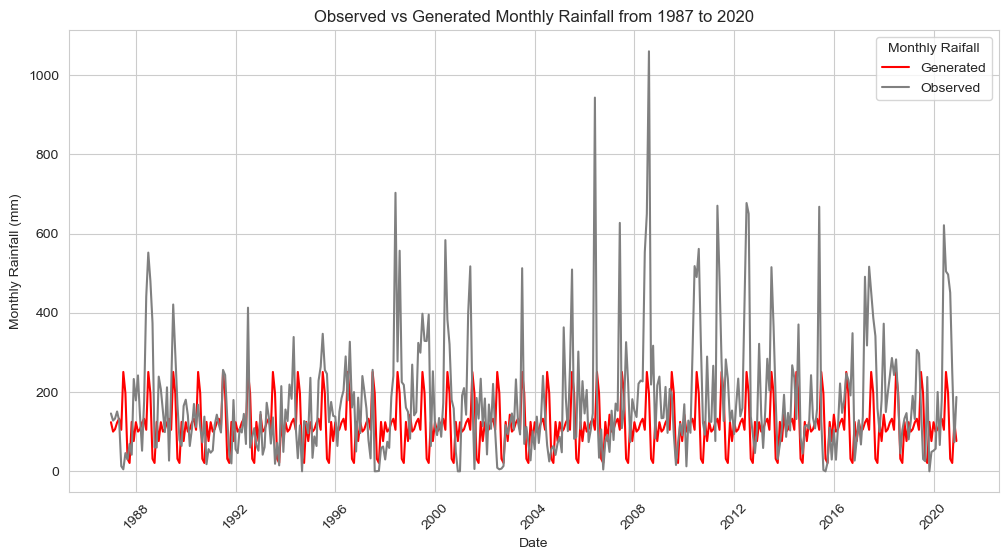

In [82]:
# line plot obs vs monthly rainfall

sb.set_style("whitegrid")
sb.set_palette("husl")
plt.figure(figsize=(12, 6))
line_gen = sb.lineplot(
    x='Months', y="Rain_Gen",color='red',
    data=gen_monthly, label="Generated")
line_obs = sb.lineplot(
    x='Months', y="Data", color='grey', 
    data=obs_monthly, label="Observed")
plt.xlabel("Date")
plt.ylabel("Monthly Rainfall (mm)")
plt.title("Observed vs Generated Monthly Rainfall from 1987 to 2020")
plt.xticks(rotation=45)
plt.legend(title="Monthly Raifall")

namafile = os.path.join(dir_out, 'Obs_vs_Generated_Monthly.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

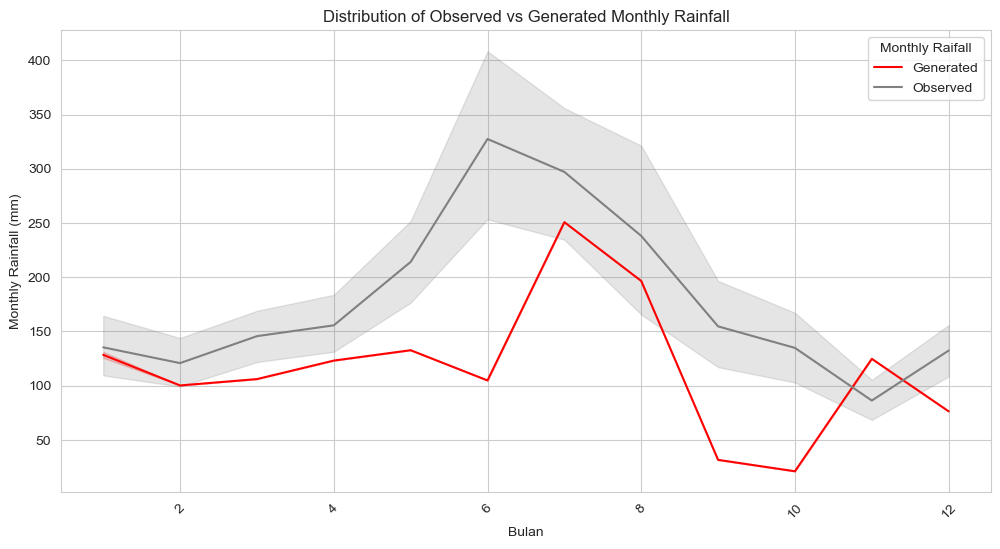

In [118]:
# melihat sebaran generated dan observed

sb.set_style("whitegrid")
sb.set_palette("husl")
plt.figure(figsize=(12, 6))
line_gen = sb.lineplot(
    x='Bulan', y="Rain_Gen",color='red',
    data=gen_monthly, label="Generated")
line_obs = sb.lineplot(
    x='Bulan', y="Data", color='grey', 
    data=obs_monthly, label="Observed")
plt.xlabel("Bulan")
plt.ylabel("Monthly Rainfall (mm)")
plt.title("Distribution of Observed vs Generated Monthly Rainfall")
plt.xticks(rotation=45)
plt.legend(title="Monthly Raifall")

namafile = os.path.join(dir_out, 'Dist_Obs_vs_Generated_Monthly.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

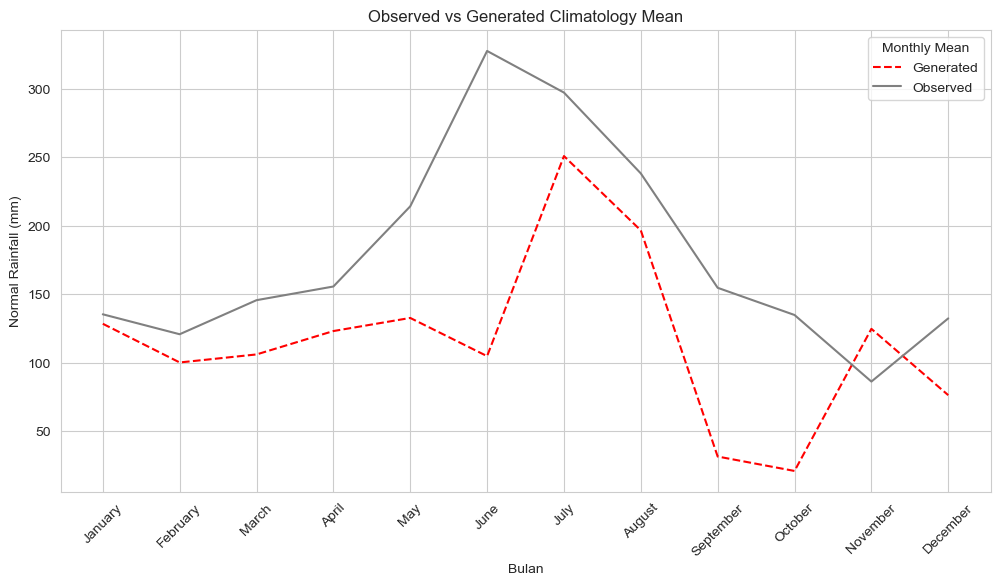

In [74]:
# creating Clim generated vs clim obs plot
import calendar

clim_df = pd.concat([obs_monthly, gen_monthly])

clim_df = clim_df.groupby(['Bulan'])\
    .mean(numeric_only=True).reset_index()
clim_df = clim_df.sort_values('Bulan')
clim_df['Bulan'] = [calendar.month_name[x] for x in clim_df['Bulan']]
clim_df = clim_df[['Bulan', 'Data', 'Rain_Gen']]
clim_df.columns = ['Bulan', 'Observed', 'Generated']

plt.figure(figsize=(12, 6))
line_gen = sb.lineplot(
    x='Bulan', y="Generated",color='red', linestyle='--',
    data=clim_df, label="Generated")
line_obs = sb.lineplot(
    x='Bulan', y="Observed", color='grey', 
    data=clim_df, label="Observed")
plt.xlabel("Bulan")
plt.ylabel("Normal Rainfall (mm)")
plt.title("Observed vs Generated Climatology Mean")
plt.xticks(rotation=45)
plt.legend(title="Monthly Mean")

namafile = os.path.join(dir_out, 'Clim_Obs_vs_Generated.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

In [75]:
rain_gen_all.loc[rain_gen_all.Rain_Gen>20]

,Bulan,Tanggal,Tahun,Rain_Gen,Date_
7,1,8,1987,24.932820,1987-01-08
8,1,9,1987,28.766619,1987-01-09
24,1,25,1987,24.651892,1987-01-25
39,2,9,1987,25.419033,1987-02-09
40,2,10,1987,20.008492,1987-02-10
...,...,...,...,...,...
226,8,15,2020,23.192713,2020-08-15
227,8,16,2020,55.719852,2020-08-16
306,11,3,2020,28.233783,2020-11-03
318,11,15,2020,45.835718,2020-11-15


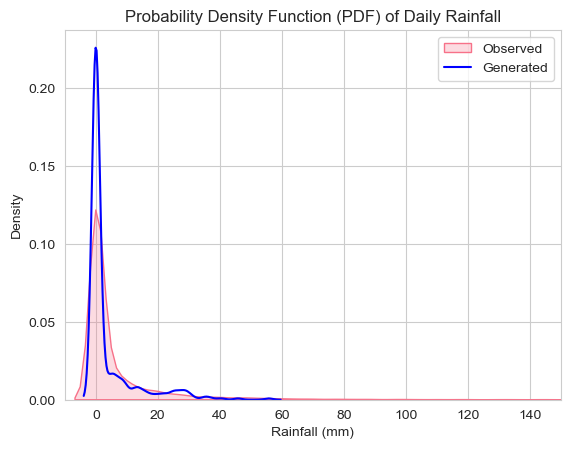

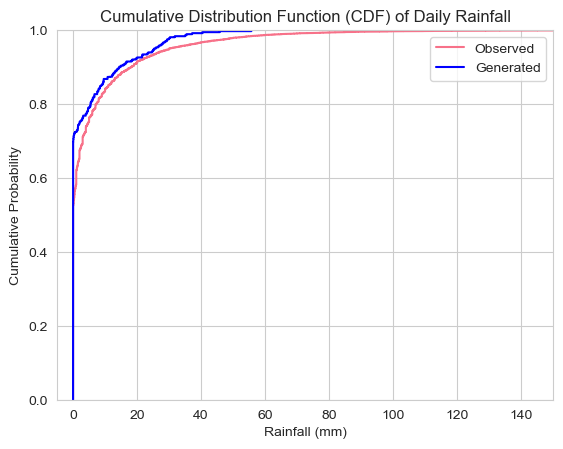

In [76]:
#now let's plot PDF and CDF for daily rainfall
sb.kdeplot(data=df_['Data'], cumulative=False, fill=True)
sb.kdeplot(data=rain_gen_all['Rain_Gen'],
           cumulative=False, fill=False, color='blue')

plt.xlabel("Rainfall (mm)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF) of Daily Rainfall")

plt.legend(labels=['Observed', 'Generated'])
plt.xlim(-10, 150)
namafile = os.path.join(dir_out, 'PDF_daily.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

# CDF
sb.ecdfplot(data=df_['Data'])
sb.ecdfplot(data=rain_gen_all['Rain_Gen'], color='blue')

plt.xlabel("Rainfall (mm)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF) of Daily Rainfall")

plt.legend(labels=['Observed', 'Generated'])
plt.xlim(-5, 150)
namafile = os.path.join(dir_out, 'CDF_daily.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

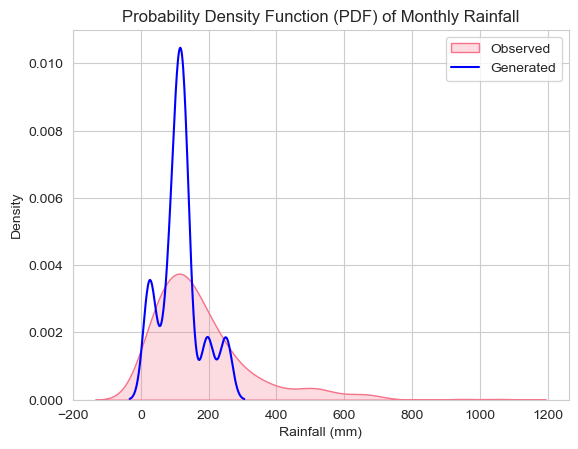

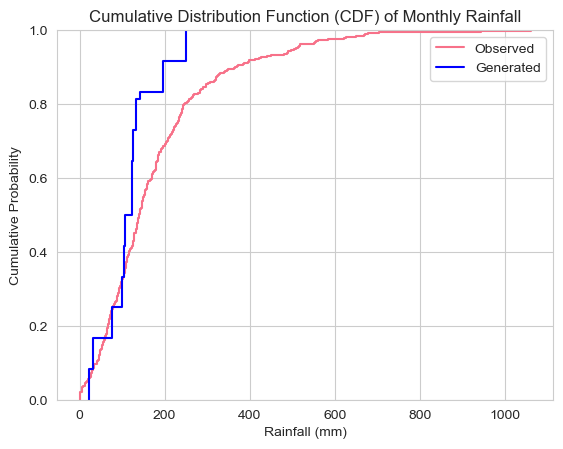

In [77]:
#now let's plot PDF and CDF for monthly
sb.kdeplot(data=obs_monthly['Data'], cumulative=False, fill=True)
sb.kdeplot(data=gen_monthly['Rain_Gen'],
           cumulative=False, fill=False, color='blue')

plt.xlabel("Rainfall (mm)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF) of Monthly Rainfall")

plt.legend(labels=['Observed', 'Generated'])
# plt.xlim(-10, 150)
namafile = os.path.join(dir_out, 'PDF_monthly.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

# CDF
sb.ecdfplot(data=obs_monthly['Data'])
sb.ecdfplot(data=gen_monthly['Rain_Gen'], color='blue')

plt.xlabel("Rainfall (mm)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF) of Monthly Rainfall")

plt.legend(labels=['Observed', 'Generated'])
# plt.xlim(-5, 150)
namafile = os.path.join(dir_out, 'CDF_monthly.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

In [78]:
obs_monthly.head(4)

,Tahun,Bulan,Months,Data
0,1987,1,1987-01-01,146.0
1,1987,2,1987-02-01,128.0
2,1987,3,1987-03-01,133.0
3,1987,4,1987-04-01,151.0


In [79]:
gen_monthly.head(4)

,Tahun,Bulan,Months,Rain_Gen
0,1987,1,1987-01-01,123.969177
1,1987,2,1987-02-01,100.197651
2,1987,3,1987-03-01,106.053961
3,1987,4,1987-04-01,123.118631


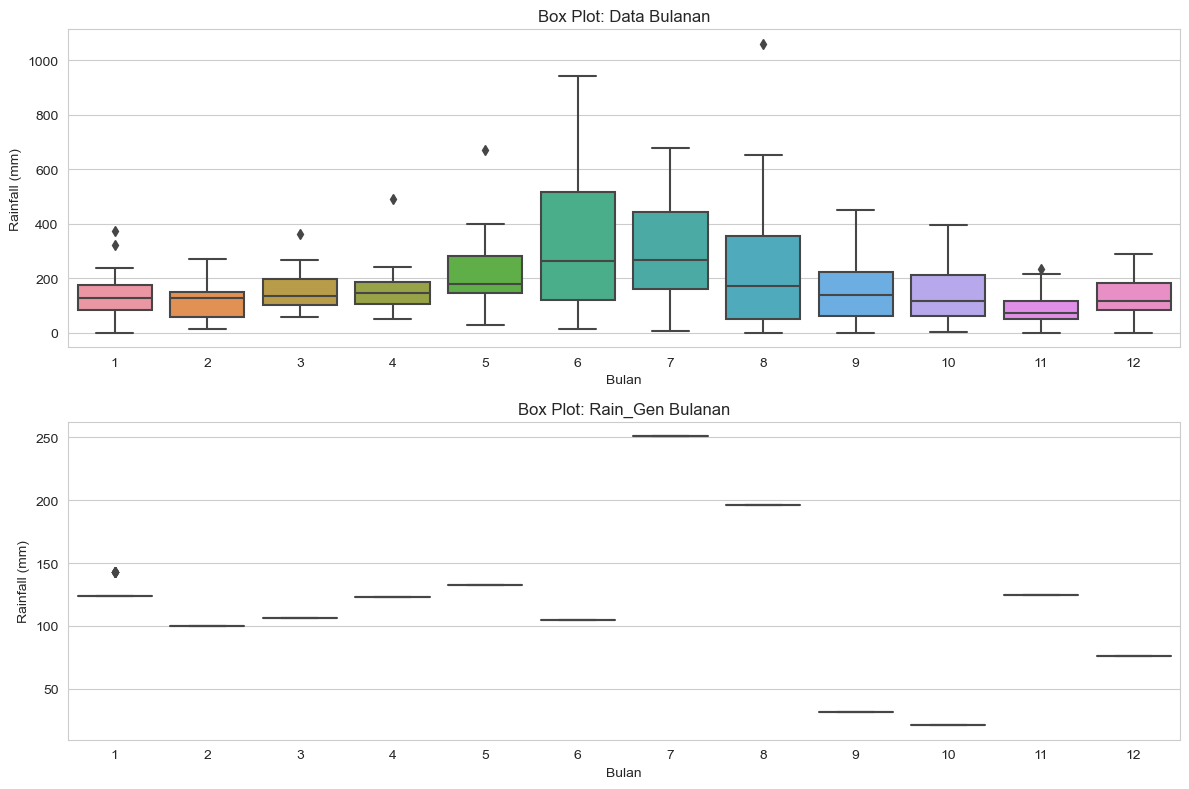

In [95]:
# box plot data bulanan hasil generator dan data obs

tabelbox = (obs_monthly, gen_monthly)
ybox = ('Data', 'Rain_Gen')
namafile = os.path.join(dir_out, 'boxplot_monthly_rainfall.png')
fig, axes = plt.subplots(nrows=len(tabelbox), ncols=1, figsize=(12, 8))

for i, (df, y) in enumerate(zip(tabelbox, ybox)):
    # Generate box plot
    sb.boxplot(data=df, x='Bulan', y=y, ax=axes[i])
    
    axes[i].set_xlabel('Bulan')
    axes[i].set_ylabel('Rainfall (mm)')
    axes[i].set_title(f'Box Plot: {y} Bulanan')

plt.tight_layout()

plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

In [94]:
daily_gabung = rain_gen_all.merge(df_[['Date_', 'Data', 'Hari_ke']], on='Date_', how='left')
daily_gabung = daily_gabung.dropna().reset_index(drop=True)

daily_avg = daily_gabung.groupby(['Hari_ke'])[['Rain_Gen', 'Data']]\
    .mean().reset_index()
daily_avg

,Hari_ke,Rain_Gen,Data
0,1,2.807750,3.424242
1,2,1.609880,3.572727
2,3,0.181022,4.893939
3,4,0.000000,7.036364
4,5,0.000000,4.096970
...,...,...,...
360,361,0.000000,4.548485
361,362,0.000000,5.403030
362,363,1.860265,3.142424
363,364,0.000000,1.433333


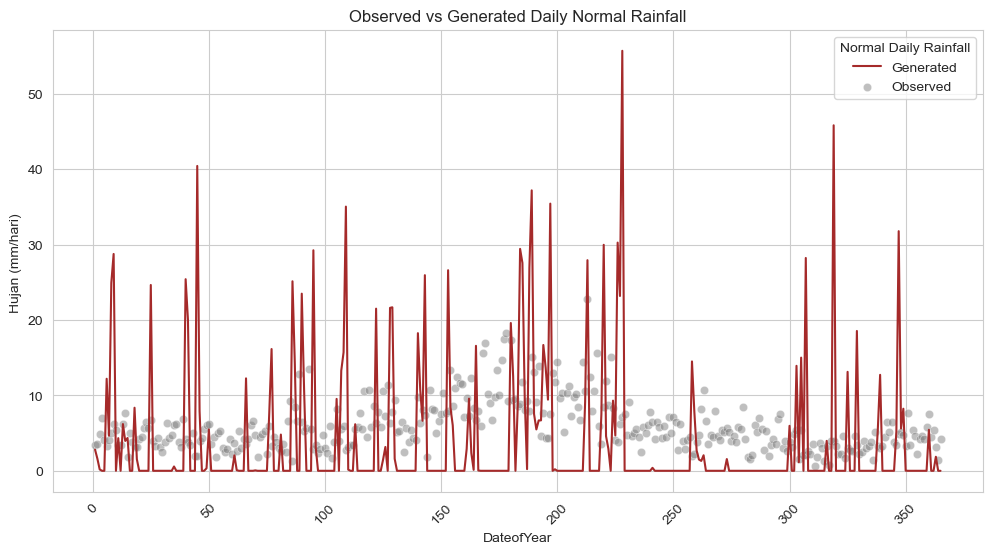

In [97]:
# plot normal hujan daily obs vs gen

plt.figure(figsize=(12, 6))
line_obs = sb.lineplot(x='Hari_ke', y="Rain_Gen", color='brown',
    data=daily_avg, label="Generated")
scatter = sb.scatterplot(
    data=daily_avg, x='Hari_ke', y='Data',
    color='grey', alpha=0.5, label='Observed')
plt.xlabel("DateofYear")
plt.ylabel("Hujan (mm/hari) ")
plt.title("Observed vs Generated Daily Normal Rainfall")
plt.xticks(rotation=45)
plt.legend(title="Normal Daily Rainfall")

namafile = os.path.join(dir_out, 'MeanDaily_Hujan_Obs_vs_Gen.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()


In [87]:
rain_gen_all

,Bulan,Tanggal,Tahun,Rain_Gen,Date_
0,1,1,1987,0.000000,1987-01-01
1,1,2,1987,0.000000,1987-01-02
2,1,3,1987,0.000000,1987-01-03
3,1,4,1987,0.000000,1987-01-04
4,1,5,1987,0.000000,1987-01-05
...,...,...,...,...,...
360,12,27,2020,0.000000,2020-12-27
361,12,28,2020,0.000000,2020-12-28
362,12,29,2020,1.860265,2020-12-29
363,12,30,2020,0.000000,2020-12-30


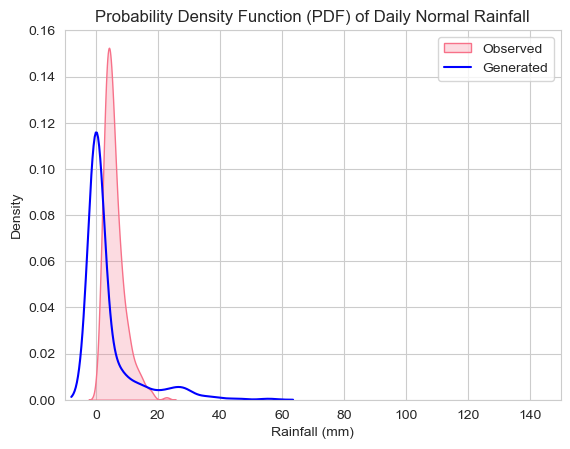

In [103]:
#now let's plot PDF and CDF for daily rainfall
sb.kdeplot(data=daily_avg['Data'], cumulative=False, fill=True)
sb.kdeplot(data=daily_avg['Rain_Gen'],
           cumulative=False, fill=False, color='blue')

plt.xlabel("Rainfall (mm)")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF) of Daily Normal Rainfall")

plt.legend(labels=['Observed', 'Generated'])
plt.xlim(-10, 150)
namafile = os.path.join(dir_out, 'PDF_daily.png')
# plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()


the plot above shows that both data share some similarity, i.e. shape of distribution. 
Both distributions follow gamma, and in some way they are kinda different. 

Let's do some non-parametrik test, to see if our normal daily generated is any different from 
observed daily data.

to do this, we will employ Mann-Whitney and t-test to check.
unfortunately, since we are analyzing rainfall data, which doesn't follow normal distribution, t-test is not necessarily the best method to use. 
so instead we will use Mann-Whitney test, as it is non-parametric and more robust than t-test.
These are the hypotheses that we will test in this notebook:

    H0 (Hipotesis Nol): Tidak ada perbedaan yang signifikan antara dua kelompok/data yang dibandingkan. Two groups have equal median
    H1 (Hipotesis Alternatif): Terdapat perbedaan yang signifikan antara dua kelompok/data yang dibandingkan. 2 groups have different median 
    
We will calculate the p_value from the test, and compare it with alpha = 0.05. the procedure are:

reject H0 if p_value < alpha

accept H1 if p_value > alpha

C:\Users\steve\anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


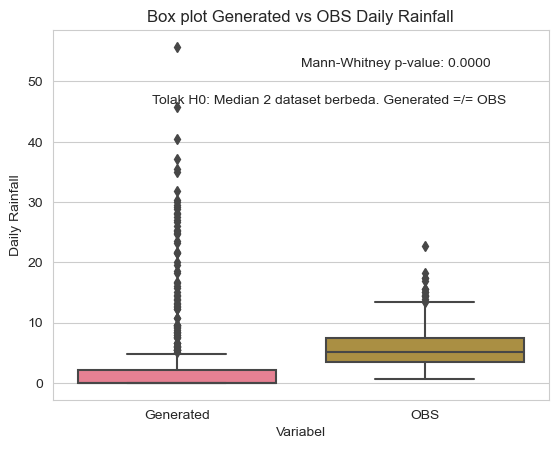

In [117]:
from scipy.stats import mannwhitneyu

ax = sb.boxplot(data=daily_avg[['Rain_Gen', 'Data']])
ax.set_xticklabels(['Generated', 'OBS'])

mw_stat, mw_p_value = mannwhitneyu(
    daily_avg['Rain_Gen'], daily_avg['Data'], alternative='two-sided')

if mw_p_value < 0.05:
    pesan='Tolak H0: Median 2 dataset berbeda. Generated =/= OBS'
else:
    pesan='Terima H1: Median 2 dataset sama. Generated=OBS'
plt.xlabel('Variabel')
plt.ylabel('Daily Rainfall')
plt.title('Box plot Generated vs OBS Daily Rainfall')

plt.text(0.5, 0.9, f'Mann-Whitney p-value: {mw_p_value:.4f}', transform=plt.gca().transAxes)
plt.text(0.2, 0.8, pesan, transform=plt.gca().transAxes)

namafile = os.path.join(dir_out, 'BoxPlot_Mann_whitney_Hujan.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()